In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(0)

# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

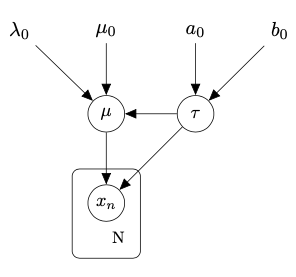

### ***Question 1.3.9:***

Implement a function that generates data points for the given model.

In [2]:
def generate_data(mu, tau, N):
    # generate N normal data points with mean mu and var 1/tau
    D = np.random.normal(loc=mu, scale=1/np.sqrt(tau), size=N)
    return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



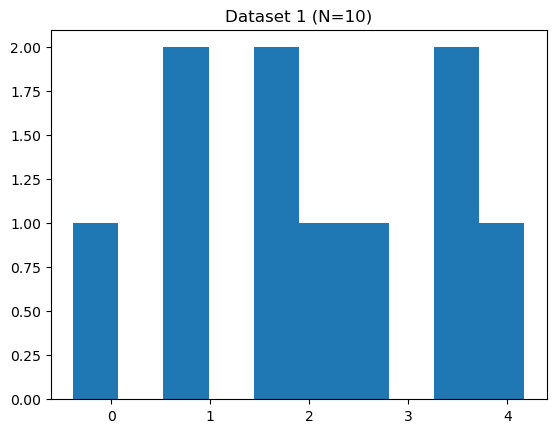

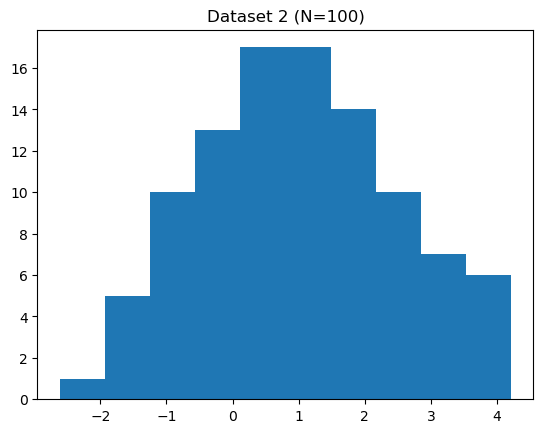

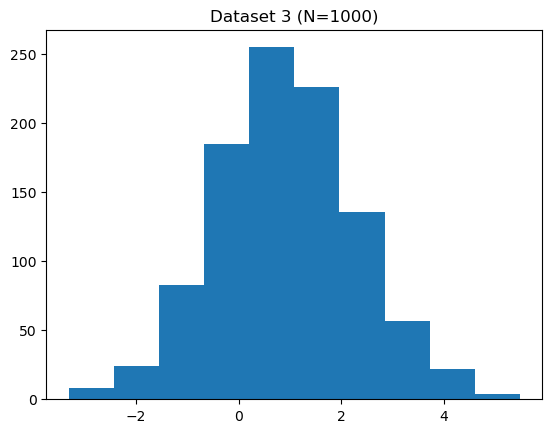

In [3]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
plt.figure(1)
plt.hist(dataset_1)
plt.title("Dataset 1 (N=10)")
plt.savefig("dataset_1_hist.png", dpi=300)

plt.figure(2)
plt.hist(dataset_2)
plt.title("Dataset 2 (N=100)")
plt.savefig("dataset_2_hist.png", dpi=300)

plt.figure(3)
plt.hist(dataset_3)
plt.title("Dataset 3 (N=1000)")
plt.savefig("dataset_3_hist.png", dpi=300)

# show figures
plt.show()

### ***Question 1.3.10:***

Find ML estimates of the variables μ and τ

In [4]:
def ML_est(data):
    mu_ml = np.mean(data)
    tau_ml = 1/np.var(data)
    return mu_ml, tau_ml

In [5]:
print(ML_est(dataset_1))
print(ML_est(dataset_2))
print(ML_est(dataset_3))

(2.043722377390312, 0.5346208711845316)
(1.0261311876389458, 0.4681785138426258)
(0.9244285751720134, 0.5309388766711757)


### ***Question 1.3.11:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [6]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
    # your implementation
    N = len(D)
    a_N = a_0 + N/2
    b_N = b_0 + 1/2*(N*np.var(D) + lambda_0*N/(lambda_0 + N)*(np.mean(D) - mu_0)**2)
    mu_N = (lambda_0*mu_0 + N*np.mean(D))/(lambda_0 + N)
    lambda_N = lambda_0 + N/2
    exact_post_dist_parameters = (a_N, b_N, mu_N, lambda_N)

    return exact_post_dist_parameters

### ***Question 1.3.12:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [7]:
# prior parameters
mu_0 = 1.0
lambda_0 = 0.1
a_0 = 1.0
b_0 = 2.0

Continue with a helper function that computes ELBO:


In [8]:
import numpy as np
from scipy.stats import gamma, norm
from scipy.special import digamma, gammaln

def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N):
    N = len(D)
    
    E_tau = a_N / b_N
    E_log_tau = digamma(a_N) - np.log(b_N)
    
    v_N = 1.0 / (lambda_N * E_tau)
    
    E_xmu2 = (D - mu_N) ** 2 + v_N
    
    E_mumu0_2 = (mu_N - mu_0) ** 2 + v_N
    
    const_normal = -0.5 * np.log(2 * np.pi)
    
    E_log_p_x = np.sum(0.5 * E_log_tau + const_normal - 0.5 * E_tau * E_xmu2)
    
    E_log_p_mu = (0.5 * np.log(lambda_0)+ 0.5 * E_log_tau + const_normal - 0.5 * lambda_0 * E_tau * E_mumu0_2)
    
    E_log_p_tau = (a_0 * np.log(b_0) - gammaln(a_0) + (a_0 - 1) * E_log_tau - b_0 * E_tau)
    
    E_log_q_mu = -0.5 * (np.log(2 * np.pi * v_N) + 1.0)
    
    E_log_q_tau = (a_N * np.log(b_N) - gammaln(a_N) + (a_N - 1) * E_log_tau - b_N * E_tau)
    
    elbo = E_log_p_x + E_log_p_mu + E_log_p_tau - E_log_q_mu - E_log_q_tau
    return elbo


Now, implement the CAVI algorithm:

In [9]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
    # make an initial guess for the expected value of tau
    initial_guess_exp_tau = a_0 / b_0
    MAX_ITER = 1000
    step_size = 0.01
    tol = 1e-6

    #inititalize
    a_N = a_0
    b_N = b_0
    mu_N = mu_0
    lambda_N = lambda_0

    a_N_out = [a_N]
    b_N_out = [b_N]
    mu_N_out = [mu_N]
    lambda_N__out = [lambda_N]

    elbo_after_init = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N)
    # Store output per iteration
    elbos = [elbo_after_init]
    
    # CAVI iterations ...
    for i in range(MAX_ITER):
        mu_star, lambda_star = update_q_mu(a_N, b_N, mu_0, lambda_0, D)
        mu_N += step_size * ( mu_star - mu_N)
        lambda_N += step_size * (lambda_star - lambda_N)

        a_star, b_star = update_q_tau(a_0, b_0, D, mu_N, lambda_N, mu_0, lambda_0) 
        a_N += step_size * (a_star - a_N)
        b_N += step_size * (b_star - b_N)
        elbos.append(compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N))

        a_N_out.append(a_N)
        b_N_out.append(b_N)
        mu_N_out.append(mu_N)
        lambda_N__out.append(lambda_N)

        if i > 1 and np.abs(elbos[i] - elbos[i-1]) < tol:
            break
        # save ELBO for each iteration, plot them afterwards to show convergence


    return a_N, b_N, mu_N, lambda_N, elbos

In [ ]:
def update_q_mu(a_n, b_n, mu_0, lambda_0, D):
    
    N = len(D)
    
    lambda_star = (lambda_0 + N)*(a_n/b_n)
    
    mu_star = (lambda_0*mu_0 + N*np.mean(D))/(lambda_0 + N)

    return mu_star, lambda_star



def update_q_tau(a_0, b_0, D, mu_n, lambda_n,mu_0, lambda_0):
    
    N = len(D)
    
    a_star = a_0 + (N+1)/2
    
    E_xn_mun = np.sum((D-mu_n)**2 + 1.0/(lambda_n))
    
    E_mu0_mun = (mu_n-mu_0)**2 + 1.0/(lambda_n)
    
    b_star = b_0 + 0.5*E_xn_mun + (lambda_0/2)*E_mu0_mun

    return a_star, b_star

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


CAVI estimates: 

Dataset:       1 | a_N:      6.4998 | b_N     10.1911 | mu_N      0.8904 | lambda_N    6.4361 | tau      0.6378
Dataset:       2 | a_N:     51.4933 | b_N     88.5708 | mu_N      0.9822 | lambda_N   58.1804 | tau      0.5814
Dataset:       3 | a_N:    501.4034 | b_N    950.9334 | mu_N      0.9054 | lambda_N  527.2136 | tau      0.5273

Posterior
Dataset:       1 | a_N:     6.0000 | b_N     9.4044 | mu_N     0.8904 | lambda_N     5.1000 | tau     0.6380
Dataset:       2 | a_N:    51.0000 | b_N    87.7199 | mu_N     0.9822 | lambda_N    50.1000 | tau     0.5814
Dataset:       3 | a_N:   501.0000 | b_N   950.1648 | mu_N     0.9054 | lambda_N   500.1000 | tau     0.5273


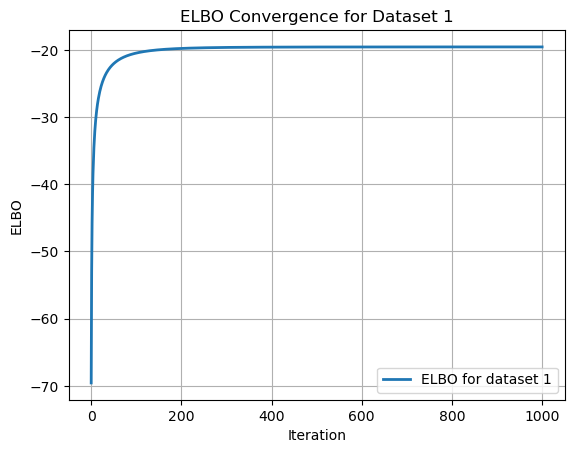

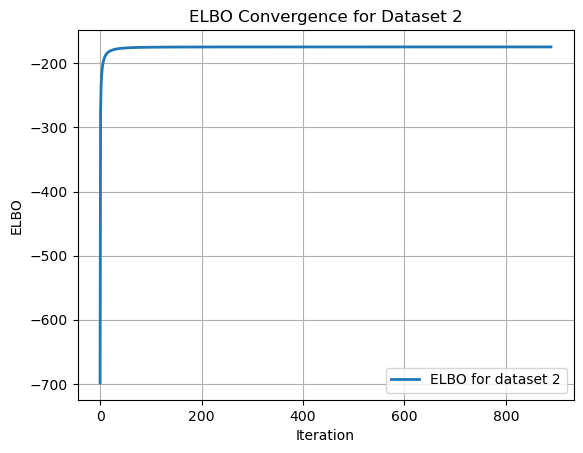

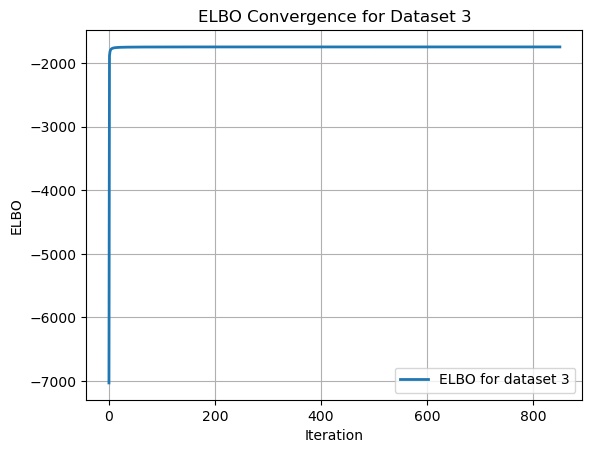

In [13]:
# Insert your main code here


# Example flow for dataset_2:
  ##  mu_ml, tau_ml = ML_est(dataset_2)
  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  plot elbos, show convergence
  ##  exact_post_dist_param = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot

# main code------------------------

mu = 1
tau = 0.5

# prior parameters
mu_0 = 1.0
lambda_0 = 0.1
a_0 = 1.0
b_0 = 2.0

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

exact_posterior = []
datasets = [dataset_1, dataset_2, dataset_3]
print("CAVI estimates: \n")

for i in range(3):
    a_N, b_N, mu_N, lambda_N, elbos = CAVI(datasets[i], a_0, b_0, mu_0, lambda_0)

    print(f"Dataset: {i+1:7d} | a_N:{a_N:12.4f} | b_N{b_N:12.4f} | mu_N{mu_N:12.4f} | lambda_N{lambda_N:10.4f} | tau{a_N/b_N:12.4f}")
    exact_posterior.append(compute_exact_posterior(datasets[i], a_0, b_0, mu_0, lambda_0))

    plt.figure(i)
    plt.plot(elbos, linewidth=2, label=f"ELBO for dataset {i+1}")
    plt.grid(True)
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("ELBO")
    plt.title(f"ELBO Convergence for Dataset {i+1}")
    plt.savefig(f"elbo_{i+1}.png", dpi=200, bbox_inches="tight")

print("\nPosterior")
for i, (aN, bN, muN, lambdaN) in enumerate(exact_posterior, start=1):
    print(
        f"Dataset: {i:7d} | "
        f"a_N: {aN:10.4f} | "
        f"b_N {bN:10.4f} | "
        f"mu_N {muN:10.4f} | "
        f"lambda_N {lambdaN:10.4f} | "
        f"tau {aN /bN:10.4f}"
    )

plt.show()